In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
#export
from nb_002 import *
from nb_003a import *

import operator
from random import sample
from torch.utils.data.sampler import Sampler

In [10]:
DATA_PATH = Path('data')
PATH = DATA_PATH/'caltech101'

# Caltech 101

In [11]:
??FilesDataset

In [12]:
classes = ["airplanes", "Motorbikes", "BACKGROUND_Google", "Faces", "watch", "Leopards", "bonsai",
    "car_side", "ketch", "chandelier", "hawksbill", "grand_piano", "brain", "butterfly", "helicopter", "menorah",
    "trilobite", "starfish", "kangaroo", "sunflower", "ewer", "buddha", "scorpion", "revolver", "laptop", "ibis", "llama",
    "minaret", "umbrella", "electric_guitar", "crab", "crayfish",]

np.random.seed(42)
train_ds,valid_ds = FilesDataset.from_folder(PATH, test_pct=0.2)

x = train_ds[1][0]
classes = train_ds.classes
c = len(classes)

len(train_ds),len(valid_ds),c

(7273, 1872, 102)

torch.Size([3, 1024, 1280])


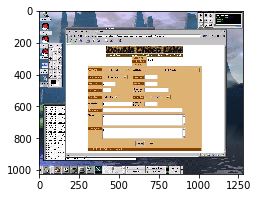

In [13]:
show_image(x, figsize=(6,3), hide_axis=False)
print(x.shape)

In [14]:
rot_m = np.array(rotate(40.)); rot_m

AttributeError: 'float' object has no attribute 'affine'

In [ ]:
#export
def affine_grid(x, matrix, size=None):
    h,w = x.shape[1:]
    if size is None: size=x.shape
    matrix[0,1] *= h/w; matrix[1,0] *= w/h
    return F.affine_grid(matrix[None,:2], torch.Size((1,)+size))

import nb_002
nb_002.affine_grid = affine_grid

In [ ]:
show_image(apply_affine(rot_m)(x), figsize=(6,3))

The goal is to replicate the [RandomResizedCrop function](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomResizedCrop) from torchvision. First we take a crop of the picture with a random size and aspect ratio and then we resize it (via interpolation) to the desired output size. 

The _scale_ parameter tells the function what percentage of the original area do we want the cropped image to have and _ratio_ tells the function what aspect ratio do we want the image to have. With these two parameters we can imply a new height and width and we can proceed to randomize the crop in the image (how much do we crop from the top, bottom, left and right borders to achieve our desired dimensions). If either the new width or the new size is bigger than our original, we will discard those dimensions since then we would have to pad. We make 10 attempts to get a new width or size, if none work out we just make it square by cropping equally from both sides of the longest side.

In [ ]:
def get_crop(t, scale, ratio):
    for attempt in range(10):
        area = t.size(1) * t.size(2)
        target_area = random.uniform(*scale) * area
        aspect_ratio = random.uniform(*ratio)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5: w, h = h, w # not sure why this happens

        if w <= t.size(2) and h <= t.size(1):
            i = random.randint(0, t.size(1) - h)
            j = random.randint(0, t.size(2) - w)
            return np.s_[:,i:i+h,j:j+w]

    # Fallback
    w = min(t.size(1), t.size(2))
    i = (t.size(1) - w) // 2
    j = (t.size(2) - w) // 2
    return np.s_[:,i:i+h,j:j+w]

In [ ]:
get_crop(x, (0.08,1.), (3./4.,4./3.))

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(8,8))
for ax in axs.flatten():
    crop_slice = get_crop(x, (0.08,1.), (3./4.,4./3.))
    y = x[crop_slice]
    y = F.interpolate(y[None], size=(224,224), mode='bilinear')
    show_image(y[0], ax)

## 1. With a start tfm

One way to implement this transformation in the pipeline is to create a transform of type start and then go through with the rest of the pipeline with the target size.

Note that scale, ratio and invert are arrays in the function that are supposed to have a size corresponding to the number of attempts before fallback. Also note that after this transform we use interpolation (in this case bilinear interpolation) to resize the output image to a standard size.

**Crop_with_ratio**

Crop_with_ratio is a transform that cuts a series of pixels from an image and outputs an image with a target area and a target aspect ratio.

_Parameters_

1. **Scale** What percentage of the original area do we want the cropped image to have.

    Domain: Real numbers from 0 to 1.
    
    
2. **Ratio** What aspect ratio do we want the image to have.

    Domain: Positive real numbers
    
    
3. **Invert** Whether we want to invert the target number of rows and target number of columns implied by *Scale* and *Ratio* (rows=columns and columns=rows).

    Domain: 0 or 1.
    
    
4. **Row_pct** Determines where to cut our image vertically on the bottom and top (which rows are left out). If <0.5, more rows will be cut in the top than in the bottom and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
5. **Col_pct** Determines where to cut our image horizontally on the left and right (which columns are left out). If <0.5, more rows will be cut in the left than in the right and viceversa (varies linearly).

    Domain: Real numbers between 0 and 1.
    
Our three parameters are related with the following equations:

1. output_rows = [**row_pct***(input_rows-**target_height**):**target_height**+**row_pct***(input_rows-**target_height**)]

2. output_cols = [**col_pct***(input_cols-**target_width**):**target_width**+**col_pct***(input_cols-**target_width**)]

In [ ]:
@reg_transform
def crop_with_ratio(x, scale:uniform, ratio:uniform, invert:rand_bool, row_pct:uniform, col_pct:uniform) -> TfmType.Start:
    #scale, ratio and invert are supposed to have a size corresponding to the number of attempts before fallback.
    for s,r,i in zip(scale, ratio, invert):
        area = x.size(1) * x.size(2)
        target_area = area * s
        cols = int(round(math.sqrt(target_area * r)))
        rows = int(round(math.sqrt(target_area / r)))

        if i: cols,rows = rows,cols

        if cols <= x.size(2) and rows <= x.size(1):
            row = int((x.size(1)-rows+1)*row_pct)
            col = int((x.size(2)-cols+1)*col_pct)
            return x[:, row:row+rows, col:col+cols].contiguous()
    # Fallback
    rows = min(x.size(1), x.size(2))
    row = (x.size(1) - rows) // 2
    col = (x.size(2) - rows) // 2
    return x[:, row:row+rows, col:col+rows].contiguous()

In [ ]:
random_resized_crop = crop_with_ratio_tfm(scale=(0.08,1.,10), ratio=(0.75,1.33,10),invert=(0.5,10),
                                          row_pct=(0,1.), col_pct=(0,1.))

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(8,12))
for ax in axs.flatten():
    #Crop
    y = random_resized_crop()(x)
    #Then resize to the output size.
    y = F.interpolate(y[None], size=(224,224), mode='bilinear')
    show_image(y[0], ax)

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(8,12))
for ax in axs.flatten():
    y = apply_tfms([random_resized_crop])(x, size=(3,224,224))
    show_image(y, ax)

## 2.The affine way

**Not working yet**

Cropping to a specific ratio is just an affine transformation that zooms in and squishes the picture in a given way. The randomness of the crop corresponds to a zoom center different from (0,0). So all of this (including the interpolation step) can be replaced with an affine transformation (then coupled with others, like a rotation).

**Zoom_squish**

Zoom_squish squishes an image and then performs a random zoom into the image.

_Parameters_

1. **Scale** / **TODO**

    Domain: Real numbers from 0 to 1.
    
    
2. **Squish** / **TODO**

    Domain: Positive real numbers
    
    
3. **Invert** / **TODO**

    Domain: True or False.
    
    
4. **Row_pct** / **TODO**

    Domain: Real numbers between 0 and 1.
    
5. **Col_pct** / **TODO**

    Domain: Real numbers between 0 and 1.

In [ ]:
@reg_affine
def zoom_squish(scale: uniform = 1.0, squish: uniform=1.0, invert: rand_bool = False, 
                row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Affine:
    for s,r, i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r < 1:
            w,h = (s/r, s*r) if i else (s*r,s/r)
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return [[w, 0, col_c],
                    [0, h, row_c],
                    [0, 0, 1.   ]]
    return [[1, 0, 0.],
            [0, 1, 0.],
            [0, 0, 1.]]

In [ ]:
random_resized_crop = zoom_squish_tfm(scale=(0.08,1.,10), squish=(0.75,1.33, 10), invert=(0.5,10), row_pct=(0,1.), col_pct=(0,1.))

In [ ]:
fig, axs = plt.subplots(4,4,figsize=(8,12))
for ax in axs.flatten():
    #Crop
    y = apply_tfms([random_resized_crop])(x, size=(3,224,224))
    show_image(y, ax)

## Deterministic RandomResizedCrop

Finally, we are going to test the validity of our implementations. If our implementations are right, a deterministic crop with ratio function, our original crop_with_ratio and zoom_squish should result in the same tranformation (if we use the same parameters).

In [ ]:
x.size()

In [ ]:
area = x.size(1) * x.size(2)
target_area = 0.5 * area
aspect_ratio = 0.8
w = int(round(math.sqrt(target_area * aspect_ratio)))
h = int(round(math.sqrt(target_area / aspect_ratio)))
w,h

In [ ]:
def crop_v1(img):
    area = img.size(1) * img.size(2)
    target_area = 0.5 * area
    aspect_ratio = 0.8

    w = int(round(math.sqrt(target_area * aspect_ratio)))
    h = int(round(math.sqrt(target_area / aspect_ratio)))

    w, h = h, w

    i = int(0.2 * (img.size(1) - h))
    j = int(0.4 * (img.size(2) - w))
    x = img[:,i:i+h, j:j+w]
    return F.interpolate(x[None], size=(224,224), mode='bilinear')

In [ ]:
show_image(crop_v1(x)[0])

In [ ]:
def crop_v2(img):
    x = crop_with_ratio(img, [0.5], [0.8], [True], 0.2, 0.4)
    x = F.interpolate(x[None], size=(224,224), mode='bilinear')
    return x[0]

In [ ]:
show_image(crop_v2(x))

In [ ]:
orig_ratio = math.sqrt(x.size(2)/x.size(1))
orig_ratio

In [ ]:
def get_zoom_mat(sw, sh, c, r):
    return [[sw, 0,  c],
            [0, sh,  r],
            [0,  0, 1.]]

In [ ]:
@reg_affine
def zoom_squish1(scale: uniform = 1.0, squish: uniform=1.0, invert: rand_bool = False, 
                row_pct:uniform = 0.5, col_pct:uniform = 0.5) -> TfmType.Affine:
    for s,r, i in zip(scale,squish, invert):
        s,r = math.sqrt(s),math.sqrt(r)
        if s * r <= 1 and s / r < 1:
            w,h = (s/r, s*r) if i else (s*r,s/r)
            w /= orig_ratio
            h *= orig_ratio
            col_c = (1-w) * (2*col_pct - 1)
            row_c = (1-h) * (2*row_pct - 1)
            return get_zoom_mat(w, h, col_c, row_c)

    if orig_ratio > 1: return get_zoom_mat(1/orig_ratio**2, 1, 0, 0.)
    else:              return get_zoom_mat(1, orig_ratio**2, 0, 0.)

In [ ]:
def crop_v3(img):
    return apply_affine(zoom_squish1([0.5], [0.8], [True], 0.2, 0.4))(img, size=(3,224,224))

In [ ]:
show_image(crop_v3(x))